# Q1. UNet - Brain MRI images

Diagnosing defective tissues from medical images is one of the most important tasks in machine learning. In this work, we are going to implement a model and train it to predict tumors in MRI images. This work includes: the following sections:
1. <a href="#Dataset">Reading the dataset</a>
2. <a href="#Model">Model implementation</a>
3. <a href="#Augmentation">Data augmentation</a>
4. <a href="#Metrics">Metrics, optimizer, and loss function</a>
5. <a href="#Training">Train the model</a>
6. <a href="#Evaluation">Evaluating the model</a>

First of all, we have to import necessary libraries as below:


In [1]:
# Import libraries for data handling and manipulation
import pandas as pd
import numpy as np
import random

# Import libraries for image processing
from PIL import Image
import cv2

# Import library for visualization
import matplotlib.pyplot as plt

# Import library for file system operations
import os

# Import library for machine learning
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Import TensorFlow and Keras modules for model building and training
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from tensorflow.keras.metrics import MeanIoU
import tensorflow.keras.backend as K

# Import library for image augmentation
import albumentations as A

2024-05-21 15:30:25.429716: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 15:30:25.429836: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 15:30:25.699300: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 1.1. <a id="Dataset">Reading the dataset</a>

In this section, we are going to read the dataset which you can find [here](https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation/data). This dataset includes 110 sets of images of 110 patients. Each set contains brain MRI images for each patient along with their corresponding masks.

Let's define a path to the dataset first.

In [2]:
data_path = "/kaggle/input/lgg-mri-segmentation/kaggle_3m"

Due to the dataset's structure, we need to create a list of all folder names. Then, we will open each folder and extract the images and masks corresponding to each case study.

In [3]:
folders = [filename for filename in os.listdir(data_path) if filename.startswith('TCGA')]

Extract images and masks from each folder, and then store all images and masks together.

In [4]:
images = []
masks = []
for filename in folders:
    folder_path = os.path.join(data_path, filename)
    folder_content = os.listdir(folder_path)
    for img in folder_content:
        if 'mask' not in img:
            images.append(os.path.join(folder_path, img))

As we want to store the image paths too, we should save a copy of them.

In [5]:
paths = images.copy()

Now, it's time to extract masks and store them.

In [6]:
for filename in images:
    name = filename[:-4] + "_mask" + filename[-4:]
    masks.append(name)

Since we are dealing with random operations, it's better to define a random seed to obtain the same results in different runs.



In [7]:
SEED = 313
random.seed(SEED)
np.random.seed(SEED)

Let's show some random images and their corresponding masks here.

In [8]:
random_images = random.sample(images, 10)
random_masks = []
for img in random_images:
    name = img[:-4] + "_mask" + img[-4:]
    random_masks.append(name)

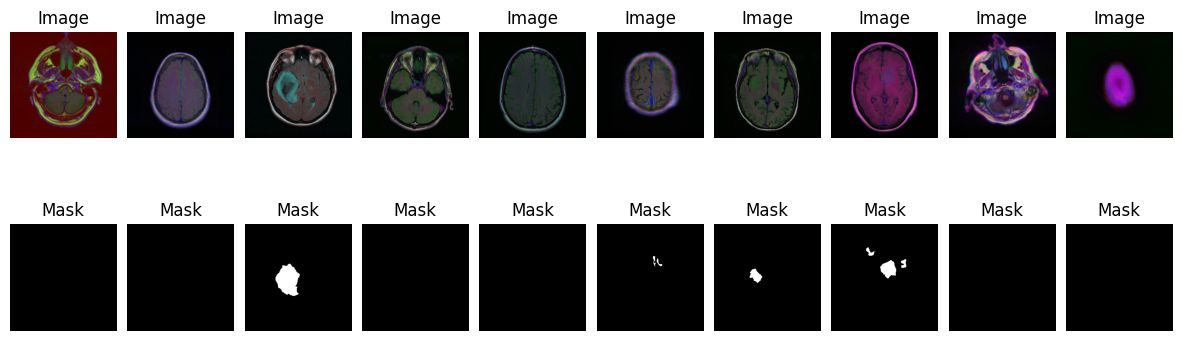

In [10]:
fig, axes = plt.subplots(2, 10, figsize=(15, 5))

for ax, path in zip(axes[0], random_images):
    image = Image.open(path)
    ax.imshow(image)
    ax.set_title("Image")
    ax.axis("off")

for ax, path in zip(axes[1], random_masks):
    image = Image.open(path)
    ax.imshow(image, cmap='gray')
    ax.set_title("Mask")
    ax.axis("off")

plt.subplots_adjust(wspace=0.1, hspace=0)

plt.show()

Now, let's make a dataframe which stores the images, masks, and paths of images.

In [11]:
data = {
    "image": images,
    "mask": masks,
    "path": paths
}
df = pd.DataFrame(data)

Let's see how is our dataframe:

In [12]:
df.head()

,image,mask,path
0,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


As you can see, it contains three columns: image, mask, and image path. Each row represents a sample image along with its corresponding mask and path.

Now, it's time to split our data. We will allocate 80% to the training set, 10% to the validation set, and 10% to the test set.

In [13]:
# Split data into train, validation, and test sets.
X_train, X_tmp, y_train, y_tmp = train_test_split(images, masks, test_size=0.2, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=SEED)

In [14]:
print(f"Number of train images:      {len(X_train)}")
print(f"Number of validation images: {len(X_val)}")
print(f"Number of test images:       {len(X_test)}")

Number of train images:      3143
Number of validation images: 393
Number of test images:       393


<hr>

## 1.2. <a id="Model">Model Implemetation</a>

In this section, we will implement the UNet model with the structure outlined in the paper.
<div style="text-align: center;">
    <img src="U-Net.png" alt="image.png">
</div>



This model contains two main sections: the encoder and the decoder. Downsampling occurs in the encoder part, where the network captures contextual information and reduces the spatial resolution of the input. The decoder then decodes the encoded data and utilizes information from the contracting path via skip connections to generate a segmentation map.

In [15]:
def unet(input_shape=(128, 128, 3), num_classes=2):
    inputs = tf.keras.Input(input_shape)
    
    # Encoder
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c5)
    
    # Decoder
    u6 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c9)
    
    # Final layer
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    
    return model

# Build the model
input_shape = (128, 128, 3) 
num_classes = 2

model = unet(input_shape, num_classes)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 256) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8, 512) │  1,180,160 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8, 512) │  2,359,808 │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │    524,544 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 512)              │            │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 7,760,130 (29.60 MB)

 Trainable params: 7,760,130 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

## <a id="Agumentation">1.3. Data Agumentation</a>

In this section, we will define a data generator that we will use to augment the data.

In [16]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, mask_paths, batch_size=16, image_size=(128, 128), num_classes=2, augmentations=None):
        assert len(image_paths) == len(mask_paths), "Image paths and mask paths must be of the same length"
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.image_size = image_size
        self.num_classes = num_classes
        self.augmentations = augmentations
        self.on_epoch_end()
        self.index = 0

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, index):
        batch_image_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_mask_paths = self.mask_paths[index * self.batch_size:(index + 1) * self.batch_size]
        
        images, masks = self.__load_data(batch_image_paths, batch_mask_paths)
        
        if self.augmentations:
            augmented_images, augmented_masks = [], []
            for img, msk in zip(images, masks):
                augmented = self.augmentations(image=img, mask=msk)
                augmented_images.append(augmented['image'])
                augmented_masks.append(augmented['mask'])
            images = np.array(augmented_images)
            masks = np.array(augmented_masks)
        
        # One-hot encode masks
        masks = self.__one_hot_encode(masks)
        
        return images, masks

    def on_epoch_end(self):
        indices = np.arange(len(self.image_paths))
        np.random.shuffle(indices)
        self.image_paths = np.array(self.image_paths)[indices]
        self.mask_paths = np.array(self.mask_paths)[indices]

    def __load_data(self, image_paths, mask_paths):
        images = [self.__load_image(img_path) for img_path in image_paths]
        masks = [self.__load_mask(msk_path) for msk_path in mask_paths]
        return np.array(images), np.array(masks)

    def __load_image(self, path):
        image = tf.keras.preprocessing.image.load_img(path, target_size=self.image_size)
        image = tf.keras.preprocessing.image.img_to_array(image)
        return image / 255.0

    def __load_mask(self, path):
        mask = tf.keras.preprocessing.image.load_img(path, target_size=self.image_size, color_mode="grayscale")
        mask = tf.keras.preprocessing.image.img_to_array(mask)
        mask = mask / 255.0
        mask = np.round(mask).astype(int)
        return mask

    def __one_hot_encode(self, masks):
        one_hot_masks = np.zeros((*masks.shape[:3], self.num_classes))
        for i in range(self.num_classes):
            one_hot_masks[..., i] = (masks[..., 0] == 1 - i).astype(int)
        return one_hot_masks

    def __iter__(self):
        self.index = 0
        return self

    def __next__(self):
        if self.index >= len(self):
            self.index = 0
            raise StopIteration
        result = self[self.index]
        self.index += 1
        return result


We considered the following transformations for augmentation using the ```albumentations``` library:
- Resize: resize images for more consistency.
- Rotate: rotate in the range of -15 to 15 degrees with a probability of 50%.
- RandomResizedCrop: crop images randomly to size 128 * 128.
- ShiftResizedRotate: shift images and crop them.
- GaussianBlur: add some noise to the images."

Also, for validation and test images we only consider resizing.

In [17]:
def train_augmentation_pipeline():
    return A.Compose([
        A.Resize(128, 128),
        A.Rotate(limit=15, p=0.5),
        A.RandomResizedCrop(128, 128, scale=(0.8, 1.0), ratio=(0.8, 1.2), p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0, p=0.5),
        A.GaussianBlur(blur_limit=(3, 7), p=0.5),
])

def valid_augmentation_pipeline():
    return A.Compose([
        A.Resize(128, 128)
    ])

In [18]:
train_augmentation_pipeline = train_augmentation_pipeline()
valid_augmentation_pipeline = valid_augmentation_pipeline()

train_generator = DataGenerator(X_train, y_train, batch_size=16, augmentations=train_augmentation_pipeline)
val_generator   = DataGenerator(X_val, y_val, batch_size=16, augmentations=valid_augmentation_pipeline)
test_generator  = DataGenerator(X_test, y_test, batch_size=16, augmentations=valid_augmentation_pipeline)

Let's display some augmented images with their corresponding masks.

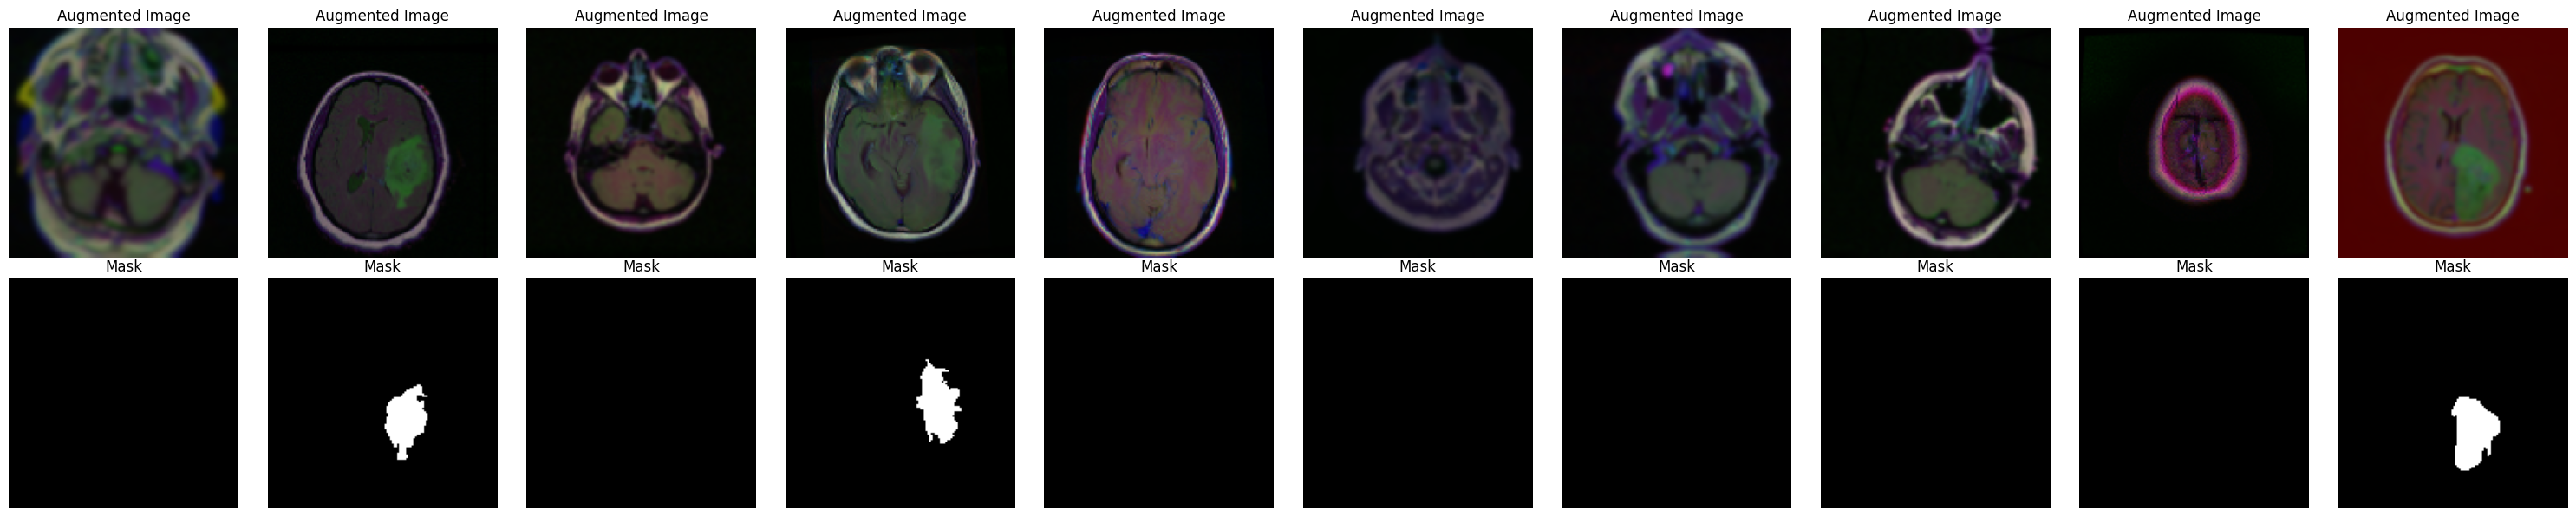

In [19]:
def display_augmented_images(data_generator, num_images=10):
    images, masks = next(iter(data_generator))
    
    num_images = min(num_images, len(images))
    fig, axs = plt.subplots(2, num_images, figsize=(3 * num_images, 6))
    
    for i in range(num_images):
        axs[0, i].imshow(images[i])
        axs[0, i].set_title('Augmented Image')
        axs[0, i].axis('off')
        
        mask = np.argmax(masks[i], axis=-1)
        tumor_area = (mask == 0).astype(np.float32)
        axs[1, i].imshow(tumor_area, cmap='gray')
        axs[1, i].set_title('Mask')
        axs[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

display_augmented_images(train_generator, num_images=10)

## 1.4. <a id="Metrics">Optimizer, metrics, and loss function</a>

In [20]:
import tensorflow.keras.backend as K

def iou_coef(y_true, y_pred, smooth=1):
    y_true = K.cast(y_true, 'float32')
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_coef(y_true, y_pred, smooth=1):
    y_true = K.cast(y_true, 'float32')
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth) / (union + smooth), axis=0)
    return dice


Define a function which will be used to plot metrics:

In [21]:
def plot_metrics(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 4, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    plt.subplot(1, 4, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.subplot(1, 4, 3)
    plt.plot(history.history['iou_coef'], label='Training IOU')
    plt.plot(history.history['val_iou_coef'], label='Validation IOU')
    plt.title('Model IOU')
    plt.ylabel('IOU')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    
    plt.subplot(1, 4, 4)
    plt.plot(history.history['dice_coef'], label='Training Dice')
    plt.plot(history.history['val_dice_coef'], label='Validation Dcie')
    plt.title('Model Dice')
    plt.ylabel('Dice')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

We used early stopping which the training process will be stopped if there is no big change in val loss in 20 epochs.

Also, we save bets weights using model checkpoint.

Batch size and learning rate are inintialized with 16 and 0.001 respectively.

In [22]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
csv_logger_callback = CSVLogger('training.log')
model_checkpoint_callback = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

batch_size = 16
lr = 0.001

## 1.5. <a id="Train">Train model</a>

Like the paper, we used ```adam``` ad the optimzer.

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy', iou_coef, dice_coef])

In [24]:
history = model.fit(train_generator, validation_data=val_generator, epochs=300, batch_size=batch_size, callbacks=[early_stopping_callback, csv_logger_callback, model_checkpoint_callback])


Epoch 1/300


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/196 ━━━━━━━━━━━━━━━━━━━━ 1:51:22 34s/step - accuracy: 0.4066 - dice_coef: 0.4996 - iou_coef: 0.3329 - loss: 0.6936

I0000 00:00:1716305486.631960      76 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.9712 - dice_coef: 0.9237 - iou_coef: 0.8855 - loss: 0.1638
Epoch 1: val_loss improved from inf to 0.02850, saving model to best_model.keras
196/196 ━━━━━━━━━━━━━━━━━━━━ 90s 284ms/step - accuracy: 0.9713 - dice_coef: 0.9239 - iou_coef: 0.8859 - loss: 0.1633 - val_accuracy: 0.9897 - val_dice_coef: 0.9902 - val_iou_coef: 0.9812 - val_loss: 0.0285
Epoch 2/300
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9892 - dice_coef: 0.9893 - iou_coef: 0.9795 - loss: 0.0311
Epoch 2: val_loss improved from 0.02850 to 0.02497, saving model to best_model.keras
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 101ms/step - accuracy: 0.9892 - dice_coef: 0.9893 - iou_coef: 0.9795 - loss: 0.0311 - val_accuracy: 0.9920 - val_dice_coef: 0.9910 - val_iou_coef: 0.9827 - val_loss: 0.0250
Epoch 3/300
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9915 - dice_coef: 0.9901 - iou_coef: 0.9810 - loss: 0.0284
Epoch 3: val_loss improved from 0.02497 to 0.02480, 

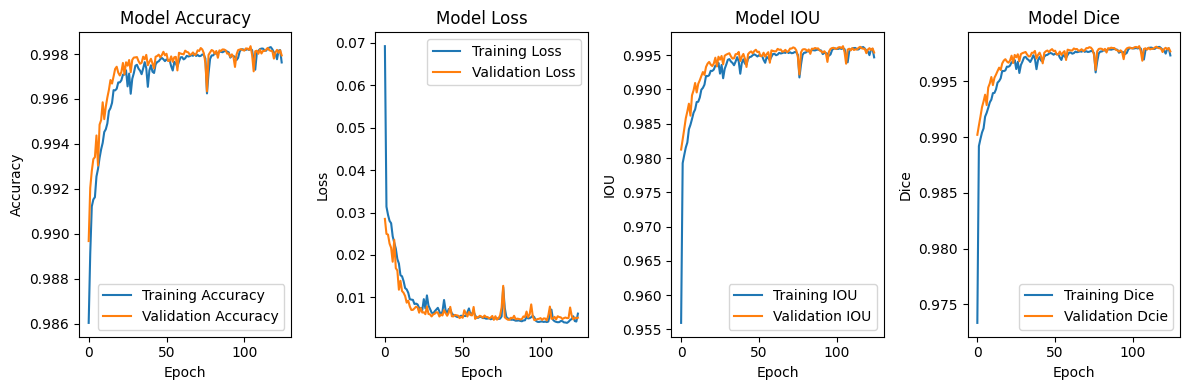

In [25]:
plot_metrics(history)

As it is obvios from the plots above, during training, accuracy, IoU, and Dice are increasing and loss decreases which mean that the training process is well enough.

## 1.6. <a id="Evaluation">Evaluate Model</a>

We are going to evaluate the model on test images.

In [26]:
test_loss, test_acc, test_iou, test_dice = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, \nTest Accuracy: {test_acc}, \nTest IOU: {test_iou}, \nTest Dice: {test_dice}")


24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 321ms/step - accuracy: 0.9980 - dice_coef: 0.9978 - iou_coef: 0.9957 - loss: 0.0059
Test Loss: 0.006038942839950323, 
Test Accuracy: 0.9980244636535645, 
Test IOU: 0.9956669211387634, 
Test Dice: 0.9978117346763611


As shown above, the test accuracy, IoU, and Dice are 99.7898%, 99.5428%, and 99.7690%, respectively. Additionally, the test loss is 0.0066. These numbers indicate that the model predicts tumor areas accurately and it is highly reliable.

Display some random test images, their ground truths, and the corresponding predicted masks.

In [27]:
import matplotlib.pyplot as plt

def plot_predictions(model, data_generator, num_images=5):
    images, true_masks = next(data_generator)
    
    images = images[:num_images]
    true_masks = true_masks[:num_images]
    
    pred_masks = model.predict(images)
    
    plt.figure(figsize=(20, 8)) 
    for i in range(num_images):
        plt.subplot(3, num_images, i + 1)
        plt.imshow(images[i])
        plt.title('Test Image')
        plt.axis('off')
        
        plt.subplot(3, num_images, num_images + i + 1)
        plt.imshow(true_masks[i][:, :, 0], cmap='gray')
        plt.title('True Mask')
        plt.axis('off')
        
        plt.subplot(3, num_images, 2 * num_images + i + 1)
        plt.imshow(pred_masks[i][:, :, 0], cmap='gray')
        plt.title('Pred Mask')
        plt.axis('off')
    
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


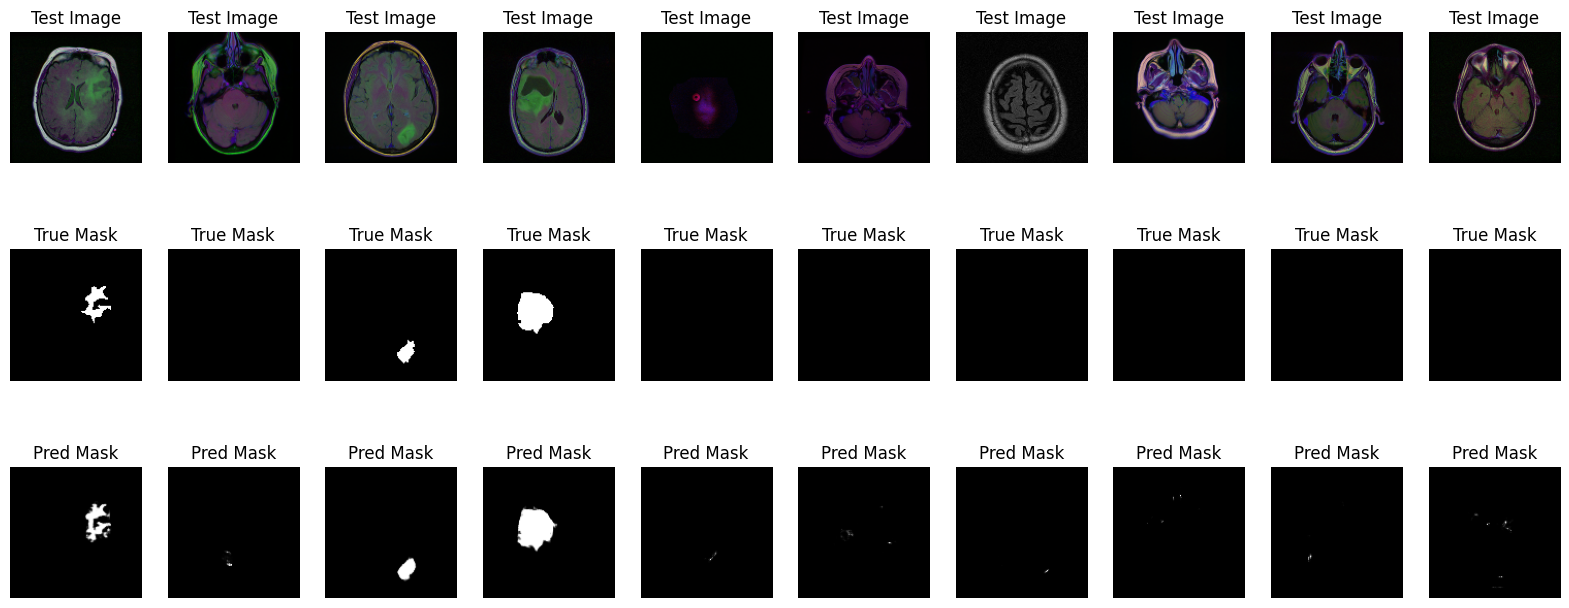

In [28]:
plot_predictions(model, test_generator, num_images=10)

As you can see, predicted masks are mostly same as the ground truths which indicates that model performes well.